<a href="https://colab.research.google.com/github/DiwanshuYadav/DeepDataHack/blob/main/main_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install dask[complete] catboost shap xgboost optuna --quiet

import dask.dataframe as dd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import shap
import warnings
warnings.filterwarnings("ignore")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 14.4 MB/s eta 0:00:00


In [5]:
df = dd.read_csv('/content/drive/MyDrive/Colab Notebooks/kiranaRO_train.csv', dtype={'InvoiceNo': 'object'})  # ⬅️ Replace with actual filename and specify dtype for 'InvoiceNo'
df = df.compute()
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,573745,22138,BAKING SET 9 PIECE RETROSPOT,6,2011-11-01 08:53:00,4.95,17419.0,United Kingdom
1,562670,22791,T-LIGHT GLASS FLUTED ANTIQUE,12,2011-08-08 13:42:00,1.25,14911.0,EIRE
2,541604,51014L,"FEATHER PEN,LIGHT PINK",24,2011-01-19 17:23:00,0.85,14572.0,United Kingdom
3,551855,22622,BOX OF VINTAGE ALPHABET BLOCKS,2,2011-05-04 15:08:00,11.95,12836.0,United Kingdom
4,561474,22384,LUNCH BAG PINK POLKADOT,100,2011-07-27 13:18:00,1.45,14680.0,United Kingdom


In [6]:
df['InvoiceNo'] = df['InvoiceNo'].astype(str)
df['IsReturn'] = df['InvoiceNo'].str.startswith('C').astype(int)


In [7]:
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]
df['CustomerID'].fillna(-999, inplace=True)
df.dropna(subset=['Description'], inplace=True)


In [8]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Hour'] = df['InvoiceDate'].dt.hour
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek
df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
df['Month'] = df['InvoiceDate'].dt.month
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Product Frequency
top_products = df['StockCode'].value_counts().head(20).index
df['TopProduct'] = df['StockCode'].apply(lambda x: 1 if x in top_products else 0)

# Customer-wise metrics
customer_freq = df.groupby('CustomerID')['InvoiceNo'].nunique().to_dict()
df['CustomerFrequency'] = df['CustomerID'].map(customer_freq)


In [9]:
from sklearn.preprocessing import LabelEncoder

le_country = LabelEncoder()
df['Country'] = le_country.fit_transform(df['Country'])
le_stock = LabelEncoder()
df['StockCode'] = le_stock.fit_transform(df['StockCode'])


In [10]:
features = ['StockCode', 'Quantity', 'UnitPrice', 'CustomerID', 'Hour', 'DayOfWeek', 'IsWeekend',
            'Month', 'TotalPrice', 'TopProduct', 'CustomerFrequency', 'Country']

X = df[features]
y = df['IsReturn']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [12]:
print("Train Distribution:\n", y_train.value_counts())
print("\nTest Distribution:\n", y_test.value_counts())


Train Distribution:
 IsReturn
0    339286
Name: count, dtype: int64

Test Distribution:
 IsReturn
0    84822
Name: count, dtype: int64


In [13]:
print("Full Data Target Distribution:\n", y.value_counts(normalize=True))


Full Data Target Distribution:
 IsReturn
0    1.0
Name: proportion, dtype: float64


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state

In [17]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
threshold = df['TotalPrice'].quantile(0.95)
df['IsHighValue'] = (df['TotalPrice'] >= threshold).astype(int)


In [18]:
df['IsHighValue'].value_counts(normalize=True)


,proportion
IsHighValue,
0,0.949984
1,0.050016


In [19]:
features = ['Quantity', 'UnitPrice', 'CustomerID']  # Add engineered features too
target = 'IsHighValue'

X = df[features]
y = df[target]


In [20]:
from sklearn.model_selection import train_test_split

# Undersample majority class
data = pd.concat([X, y], axis=1)
class_0 = data[data[target] == 0]
class_1 = data[data[target] == 1]

class_0_sampled = class_0.sample(n=len(class_1)*2, random_state=42)
balanced_data = pd.concat([class_0_sampled, class_1])
balanced_data = balanced_data.sample(frac=1, random_state=42)

X = balanced_data[features]
y = balanced_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [21]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
cat = CatBoostClassifier(verbose=0)
rf = RandomForestClassifier()

voting = VotingClassifier(estimators=[
    ('xgb', xgb), ('cat', cat), ('rf', rf)
], voting='soft')

voting.fit(X_train, y_train)
y_pred = voting.predict(X_test)


In [22]:
print("F1 Score:", f1_score(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


F1 Score: 0.9984689671416794
AUC-ROC: 0.9989982877271185
Accuracy: 0.9989786297925832
[[8476    9]
 [   4 4239]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8485
           1       1.00      1.00      1.00      4243

    accuracy                           1.00     12728
   macro avg       1.00      1.00      1.00     12728
weighted avg       1.00      1.00      1.00     12728



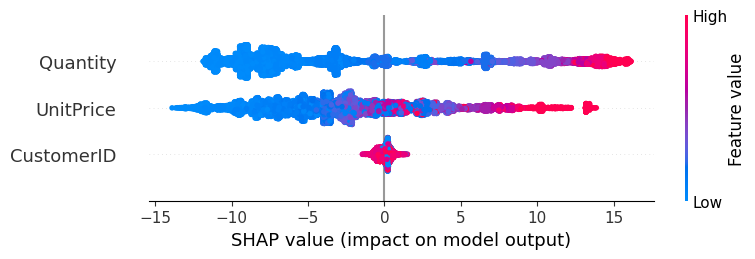

In [24]:
explainer = shap.TreeExplainer(voting.estimators_[0]) # Access the fitted xgb model within the VotingClassifier
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, max_display=10)

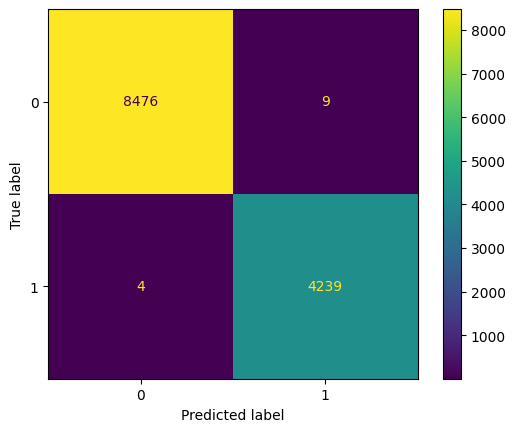

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


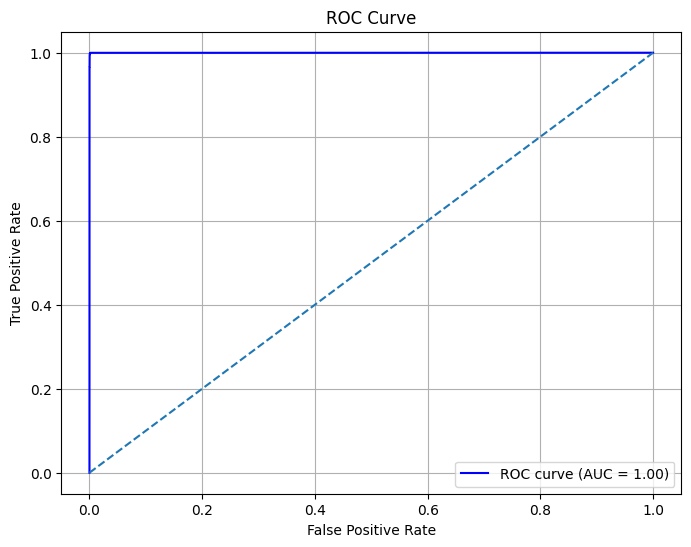

In [26]:
from sklearn.metrics import roc_curve, auc

y_probs = voting.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


In [27]:
cat.fit(X_train, y_train)
importances = cat.get_feature_importance(prettified=True)
print(importances)


   Feature Id  Importances
0    Quantity    51.636844
1   UnitPrice    48.097179
2  CustomerID     0.265977


In [32]:
import dask.dataframe as dd

# Replace 'yourfile.csv' with the actual path to your CSV file
file_path = '/content/drive/MyDrive/Colab Notebooks/kiranaRO_train.csv'  # Update with your file path

# Load with Dask, specifying dtype for 'InvoiceNo'
df_dask = dd.read_csv(file_path, dtype={'InvoiceNo': 'object'}) # Specify the dtype for the problematic column

# Convert to Pandas (after sampling/cleaning)
df = df_dask.sample(frac=0.3).compute()